# Interpolation Comparison in 2D

Comparing `scipy.interpolate.interpn` with `method='linear'` and `method='splinef2d'`, and `scipy.ndimage.map_coordinates`.


We calculate the x-directed electric field due to a rotated, finite length electric dipole source in a homogeneous fullspcae with vertical transverse electrical isotropy (see below under the section `empymod` for the exact model parameters).

For the semi-analytical 1D calculation we use `empymod`, and for the full 3D calculation emg3d, see https://empymod.github.io for both.

The semi-analytical solution is calculated on a very fine grid every 5 meters, whereas the much more expensive 3D model is calculated on a stretched grid, starting with cell width of 20 meters which increases up to 200 m. Different interpolation methods available in `SciPy` are compared. Here, the problem is reduced to a 2D problem. However, in general this is a 3D problem, for which `scipy.interpolate.interpn` is ONLY AVAILABLE for the methods `linear` and `nearest`, BUT NOT for `spline`.

#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

Recommended:

```
pip install discretize
conda install -c prisae empymod emg3d
```

However, also possible is
```
pip install discretize empymod emg3d
```

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, ndimage

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

## `empymod`

Semi-analytical solution on a regular grid from -2560 meters to 2560 meters in x- and y-directions, calculated every 5 meters.  (Analytical in the wavenumber-frequency domain, but then integrated with 5 points to get a finite length dipole and transformed to space-frequency domain with digital linear filters.)

In [3]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
aniso = np.sqrt(2.)    # Anisotropy
resv = resh*aniso**2   # Vertical resistivity
src = [-50, 50, -30, 30, -320., -280.]  # Source: [x1, x2, y1, y2, z1, z2]
src_c = np.mean(np.array(src).reshape(3, 2), 1).ravel()  # Center points of course
zrec = -400.           # Receiver depth
freq = 0.77            # Frequency
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-za
    'src': [src[0], src[1], src[2], src[3], -src[4], -src[5]],
    'depth': [],
    'res': resh,
    'aniso': aniso,
    'strength': strength,
    'srcpts': 5,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

Calculate the result and just get the real part for this comparison.

In [4]:
epm_fs = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], verb=3, **model).reshape(np.shape(rx)).real


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1.41421
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  0.77
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  123.288
     > strength[A] :  3.14159
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  300
     > azimuth [°] :  30.9638
     > dip     [°] :  -18.9318
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   : 

## `emg3d`

Smallest cell is 20x20x20 meters at source location. Cells are stretched; biggest cells are roughly 161x161x200 meters.

In [5]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = emg3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, x0=-400, x1=0)
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,408.71      4,228.19     20.00    160.52    1.03
   y    128     -4,408.71      4,228.19     20.00    160.52    1.03
   z    128     -4,388.71      4,379.08     20.00    199.27    1.04

In [6]:
# Get the model
pmodel = emg3d.utils.Model(pgrid, res_x=resh, res_z=resv, freq=freq)

# Get the source field
sfield = emg3d.utils.get_source_field(pgrid, src, freq, strength)

# Calculate the electric field
pfield = emg3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 14:34:24 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]     error                 l2:[last/init, last/prev] l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [14:34:38] 1.999e-05 after  1 F-cycles; [3.057e-02, 3.057e-02] 0 0
   [14:34:51] 1.818e-06 after  2 F-cycles; [2.781e-03, 9.097e-02] 0 0
   [14:35:04] 2.290e-07 after  3 F-cycles; [3.503e-04

Get the 2D slice at receiver depth, just the real part for this comparison.

In [7]:
ind = 53
print(np.allclose(pgrid.vectorNz[ind], zrec))  # Check it is at receiver depth.
data = pfield.fx[:, :, ind].real

True


## Interpolate

In [8]:
def interpn_ndimage(points, values, xi):

    def spline1d(x, xnew):
        fn = interpolate.interp1d(x, np.arange(len(x)), kind='cubic')
        return fn(xnew.ravel())
    
    i = spline1d(points[0], xi[0])
    j = spline1d(points[1], xi[1])

    coords = np.vstack([i, j])

    return ndimage.map_coordinates(values, coords, order=3).reshape(rx.shape)

emg3d_ndimage = interpn_ndimage((pgrid.vectorCCx, pgrid.vectorNy), data, (rx, ry))

In [9]:
emg3d_linear = interpolate.interpn((pgrid.vectorCCx, pgrid.vectorNy), data, (rx, ry), method='linear')
emg3d_spline = interpolate.interpn((pgrid.vectorCCx, pgrid.vectorNy), data, (rx, ry), method='splinef2d')
emg3d_ndimage = interpn_ndimage((pgrid.vectorCCx, pgrid.vectorNy), data, (rx, ry))

## Plot

### Helper routines for plotting

In [10]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def set_axis(ax, name, x):
    """Set axis."""
    plt.sca(ax)
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")

def plot_error(ax, data1, data2):
    cf = ax.pcolormesh(
        x/1000, x/1000, np.log10(np.abs((data1-data2)/data1)*100),
        vmin=-2, vmax=2, linewidth=0, rasterized=True,
        cmap=discrete_cmap(8, "RdBu_r"))
    return cf

### Actual comparison

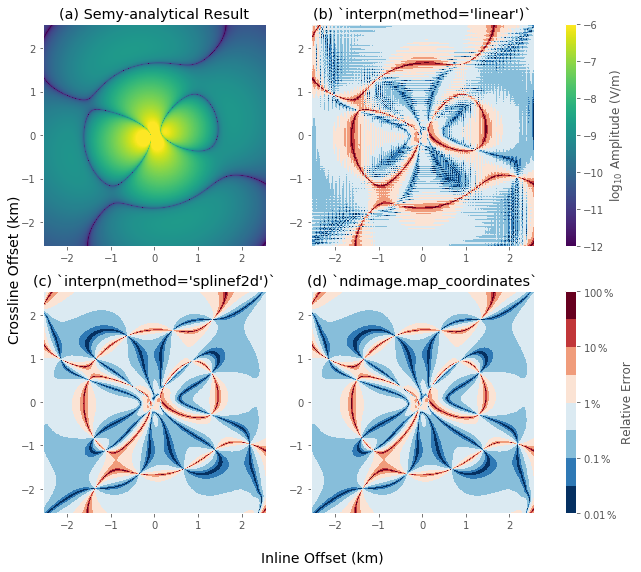

In [11]:
fig, axs = plt.subplots(figsize=(11, 9), nrows=2, ncols=2)

# Plot DATA
set_axis(axs[0, 0], "(a) Semy-analytical Result", x)
cf0 = axs[0, 0].pcolormesh(
    x/1000, x/1000, np.log10(np.abs(epm_fs)), linewidth=0,
    rasterized=True, cmap="viridis", vmin=-12, vmax=-6)

# Plot Linear
set_axis(axs[0, 1], "(b) `interpn(method='linear')`", x)
plot_error(axs[0, 1], epm_fs, emg3d_linear)

# Plot Spline
set_axis(axs[1, 0], "(c) `interpn(method='splinef2d')`", x)
plot_error(axs[1, 0], epm_fs, emg3d_spline)

# Plot ndimage
set_axis(axs[1, 1], "(d) `ndimage.map_coordinates`", x)
cf1 = plot_error(axs[1, 1], epm_fs, emg3d_ndimage)

# Colorbars
fig.colorbar(cf0, ax=axs[0, :], label=r"$\log_{10}$ Amplitude (V/m)")
cbar = fig.colorbar(cf1, ax=axs[1, :], label=r"Relative Error")
cbar.set_ticks([-2, -1, 0, 1, 2])
cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

# Axis label
fig.text(0.4, 0.05, "Inline Offset (km)", fontsize=14)
fig.text(0.08, 0.6, "Crossline Offset (km)", rotation=90, fontsize=14)

plt.savefig('InterpolationComparison.png', bbox_inches='tight')
plt.show()

---
---
# Pure analytical example, same modeller for fined and coarse grid.

## Model parameters

In [12]:
model = {
    'src': [0, 0, 300],  # Source at (0, 0, 0)
    'res': 1,            # Resistivity 1 Ohm.m
    'freqtime': 1,       # Frequency 1 Hz
    'verb': 1,
}

zrec = 100.              # Receiver depth

## Calculate analytical solution for regular, fine grid

Calculate it on a 5m x 5m grid.

In [13]:
x1 = (np.arange(1025))*5-2560
r1x = np.repeat([x1,], np.size(x1), axis=0)
r1y = r1x.transpose()

epm_fs = empymod.analytical(
    rec=[r1x.ravel(), r1y.ravel(), zrec], **model
).reshape(np.shape(r1x)).real

* WARNING :: Offsets < 0.001 m are set to 0.001 m!


## Calculate analytical solution for stretched grid

Calculate it on a stretched grid, starting at 0.6 m up to 243 m cell width.

In [14]:
x2 = np.cumsum(1.1**np.arange(64))*.6
x2 = np.r_[-x2[::-1], 0.001, x2]
x2size = np.diff(x2)
print(f"Stretched grid; min: {np.round(np.abs(x2size).min(), 2)} m, max: {np.round(np.abs(x2size).max(), 2)}\n")

r2x = np.repeat([x2,],np.size(x2),axis=0)
r2y = r2x.transpose()
epm_fs2 = empymod.analytical(
    rec=[r2x.ravel(), r2y.ravel(), zrec], **model
).reshape(np.shape(r2x)).real

Stretched grid; min: 0.6 m, max: 243.16



# Interpolate

In [15]:
epm_fs_linear = interpolate.interpn((x2, x2), epm_fs2, (r1y, r1x), method='linear')
epm_fs_scubic = interpolate.interpn((x2, x2), epm_fs2, (r1y, r1x), method='splinef2d')

# Plot

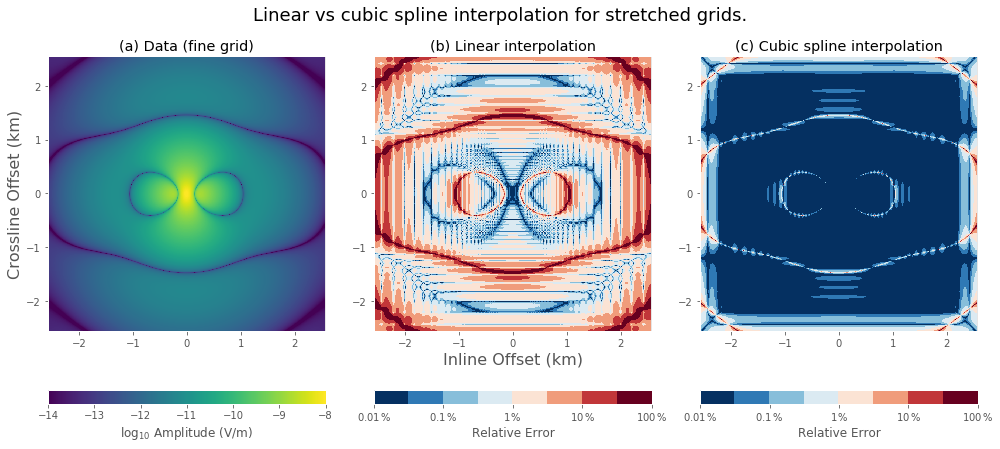

In [16]:
fig, axs = plt.subplots(figsize=(14, 6))

# Plot DATA
plt.subplot(131)
plt.title("(a) Data (fine grid)")
cf0 = plt.pcolormesh(
    x1/1000, x1/1000, np.log10(np.abs(epm_fs)), linewidth=0,
    rasterized=True, cmap="viridis", vmin=-14, vmax=-8)
plt.ylabel("Crossline Offset (km)", fontsize=16)
plt.xlim(min(x1)/1000, max(x1)/1000)
plt.ylim(min(x1)/1000, max(x1)/1000)
plt.axis("equal")
fig.colorbar(cf0, label=r"$\log_{10}$ Amplitude (V/m)", orientation='horizontal')

    
# Plot Linear
plt.subplot(132)
plt.title("(b) Linear interpolation")
cf1 = plt.pcolormesh(
        x1/1000, x1/1000, np.log10(np.abs((epm_fs-epm_fs_linear)/epm_fs)*100),
        vmin=-2, vmax=2, linewidth=0, rasterized=True,
        cmap=discrete_cmap(8, "RdBu_r"))
plt.xlim(min(x1)/1000, max(x1)/1000)
plt.ylim(min(x1)/1000, max(x1)/1000)
plt.axis("equal")
plt.xlabel("Inline Offset (km)", fontsize=16)
cbar = fig.colorbar(cf1, label=r"Relative Error", orientation='horizontal')
cbar.set_ticks([-2, -1, 0, 1, 2])
cbar.ax.set_xticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

# Plot cubic
plt.subplot(133)
plt.title("(c) Cubic spline interpolation")
cf2 = plt.pcolormesh(
        x1/1000, x1/1000, np.log10(np.abs((epm_fs-epm_fs_scubic)/epm_fs)*100),
        vmin=-2, vmax=2, linewidth=0, rasterized=True,
        cmap=discrete_cmap(8, "RdBu_r"))
plt.xlim(min(x1)/1000, max(x1)/1000)
plt.ylim(min(x1)/1000, max(x1)/1000)
plt.axis("equal")
cbar = fig.colorbar(cf2, label=r"Relative Error", orientation='horizontal')
cbar.set_ticks([-2, -1, 0, 1, 2])
cbar.ax.set_xticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

plt.suptitle('Linear vs cubic spline interpolation for stretched grids.', fontsize=18, y=1.05)

plt.tight_layout()
plt.savefig('InterpolationComparison-analytical.png', bbox_inches='tight')

plt.show()

In [17]:
emg3d.Versions([empymod, discretize])

------------------------------------------------------
  Mon Jun 10 14:37:26 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.3 : numpy
          1.2.1 : scipy
         0.43.1 : numba
      0.6.3dev0 : emg3d
          7.5.0 : IPython
          3.0.3 : matplotlib
          1.8.2 : empymod
          0.4.4 : discretize

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------